# SIR Modeling for COVID-19

Objectives: Look at the rate of COVID-19 growth by different regions and estimate the SIR curve.

* The recovery rate and overall fatality rate should be fixed.
* The infection rate should depend on local population density and social distancing measures (unique to each region).

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import os
import pickle
import requests

In [3]:
with open('./data/us_combined_df.pkl', 'rb') as f:
    county_df = pickle.load(f)


# SIR model for large counties

Given that I only have access to county-level infections and populations, here I am applying a [simple SIR model](https://mathworld.wolfram.com/Kermack-McKendrickModel.html) to fit the curve to each county. The SIR formula is:

$$
\frac{dS}{dt} = -\beta SI \\
\frac{dI}{dt} = \beta SI - \gamma I \\
\frac{dR}{dt} = \gamma I
$$

We can use the Taylor expansion to simulate the process using approximations at every fractional time step. Note that higher order terms can be derived by applying the chain rule and substituting in the differential equations above, but with time steps much smaller than contact and recovery times, a first order approximator is probably sufficient for a very accurate model.

$$
\begin{matrix}
S(t+\delta) &= S(t) &- \beta S(t)I(t)\delta &+ ...\\
I(t+\delta) &= I(t) &+ (\beta S(t) - \gamma)I(t)\delta &+ ...\\
R(t+\delta) &= R(t) &+ \gamma I(t)\delta &+... \\
\end{matrix}
$$

## Limitations

Note that this SIR model does not consider factors such as variable recovering time or death rate, migration, etc.


In [144]:
def compute_sir(sampling_rate, total_days, pop, infected, contacts_per_day, days_to_recover):
    """Simulates the SIR output over a number of days using small fraction-of-day time steps.
    
    Args:
        dt: The time step in days for simulating the SIR model.
        total_days: The total time to simulate.
        pop: The population of the area we are simulating.
        infected: The starting number of infected individuals.
        contacts_per_day: The number of people each infected individual infects per day
          at the start of simulation (nearly everyone is susceptible).
        days_to_recover: The number of days it takes someone to recover from the disease.
        
    Returns:
        Time indices, and associated susceptible, infected, and recovered populations
        
    """
    s = [1.0]
    i = [float(infected) / pop]
    r = [0.0]
    beta = contacts_per_day
    gamma = 1.0 / days_to_recover
    dt = 1.0 / sampling_rate
    for t in np.arange(0, T-dt, dt):
        prev_s = s[-1]
        prev_i = i[-1]
        prev_r = r[-1]
        # First order modeling
        s.append(prev_s - beta * prev_s * prev_i * dt)
        i.append(prev_i + (beta * prev_s - gamma) * prev_i * dt)
        r.append(prev_r + gamma * prev_i * dt)
        
    s = np.array(s)
    i = np.array(i)
    r = np.array(r)
    return np.arange(0, T, dt), pop * s, pop * i, pop * r

def sir_param_search(data, contacts_per_day_grid, death_rate_grid, days_to_recover_grid, sampling_rate, total_days):
    """Param search for SIR model.
    
    Args:
      data: Dataframe holding death values.
      contacts_per_day_grid: An array holding values to try out for number of contacts per day.
      death_rate_grid: An array holding values to try out for fraction of infected that die.
      days_to_recover_grid: An array holding values to try out for number of days before infected person recovers.
      sampling rate: Number of samples per day used for SIR simulation.
      total_days: Total number of days to simulate 
    """
    infected = 1.0
    best_contacts = 0
    best_death_rate = 0
    best_days_to_recover = 0
    best_mse = 1e12
    population = data['Population'].iloc[0]
    actual_deaths = data['Deaths'].to_numpy()
    for contacts_per_day in contacts_per_day_grid:
        for death_rate in death_rate_grid:
            for days_to_recover in days_to_recover_grid:
                t, s, i, r = compute_sir(
                    sampling_rate,
                    total_days, population * death_rate,
                    infected,
                    contacts_per_day,
                    days_to_recover
                )
                mse = np.mean(np.square(actual_deaths - r[:data.shape[0]*10:10]))
                if mse < best_mse:
                    best_contacts = contacts_per_day
                    best_death_rate = death_rate
                    best_days_to_recover = days_to_recover
                    best_mse = mse

    t, s, i, r = compute_sir(
        sampling_rate,
        total_days,
        population * best_death_rate,
        infected,
        best_contacts,
        days_to_recover
    )
    return t, s, i, r, best_contacts, best_death_rate, best_days_to_recover, best_mse
    
def plot_sir_model(r, i, data, sampling_rate, name):
    """Plot the model death rates and total deaths vs actual data.
    
    Args:
        r: Array holding recovery values
        data: Dataframe holding death values.
        sampling_rate: Number of samples per day used to simulate the model.
        
        
    """
    plot_start_time = data['Date'].min().timestamp()
    plot_step_size = dt * 24 * 60 * 60
    plot_end_time = plot_start_time + T * 24 * 60 * 60 
    plot_timestamps = np.arange(plot_start_time, plot_end_time, plot_step_size)
    plot_dates = [datetime.utcfromtimestamp(x) for x in plot_timestamps]
    print('peak date', plot_dates[np.argmax(i)])
    # Plot peak infection
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates[:-sampling_rate],
            (r[sampling_rate:] - r[:-sampling_rate]),
            c='g',
            label='model death rate',
            linewidth=4)
    ax.plot(data['Date'].to_list()[:-1],
            (data['Deaths'] - data['Deaths'].shift())[1:], label='actual death rate', c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.plot()
    
    # Plot recovery
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.ticklabel_format(useOffset=False)
    ax.ticklabel_format(style='plain')
    ax.plot(plot_dates, r, c='g',
            label='model deaths', linewidth=4)
    ax.plot(data['Date'].to_list(), data['Deaths'], label='actual deaths', c='r', linewidth=4)
    ax.set_title('SIR model for ' + name)
    ax.set_xlabel('Number of days')
    ax.set_ylabel('Number of individuals')
    plt.legend()
    plt.show()

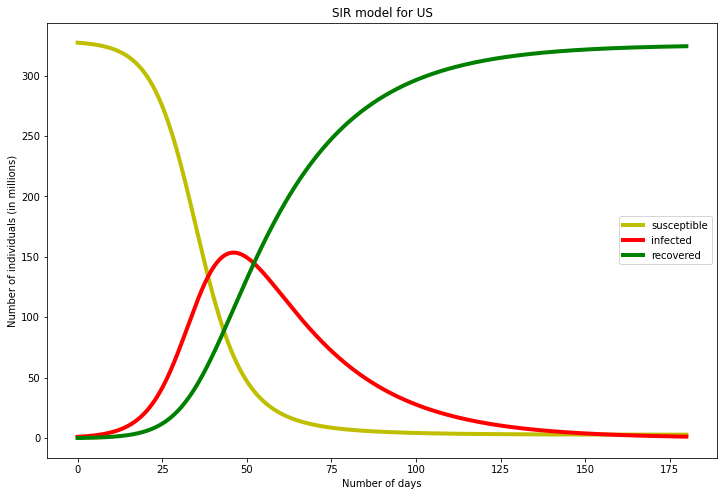

In [49]:
# @title Test out a model plot
sampling_rate = 10.0 # In days
T = 180 # Total number of days
population = 327.2 # Population in the US in millions
infected = 1.0 # Starting population infected
contacts_per_day = 0.2 # Average contacts per day for people
days_to_recover = 24 # Average days to recover (Avg 10 days until symptoms + 14 days after symptoms fade)

t, s, i, r = compute_sir(sampling_rate, T, population, infected, contacts_per_day, days_to_recover)

fig, ax = plt.subplots(figsize=(12, 8))
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
ax.plot(t, s, c='y', label='susceptible', linewidth=4)
ax.plot(t, i, c='r', label='infected', linewidth=4)
ax.plot(t, r, c='g', label='recovered', linewidth=4)
ax.set_title('SIR model for US')
ax.set_xlabel('Number of days')
ax.set_ylabel('Number of individuals (in millions)')
plt.legend()
plt.show()


## Try Model on NYC death rates

,FIPS,County,Province_State,Country_Region,Date,Cases,Deaths,Population
19123,36061.0,New York City,New York,US,2020-03-02,1,0,1628706
19124,36061.0,New York City,New York,US,2020-03-03,1,0,1628706
19125,36061.0,New York City,New York,US,2020-03-04,1,0,1628706
19126,36061.0,New York City,New York,US,2020-03-05,4,0,1628706
19127,36061.0,New York City,New York,US,2020-03-06,11,0,1628706


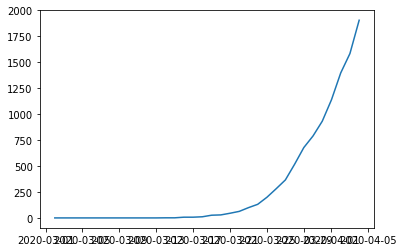

In [50]:
new_york_df = county_df[county_df.FIPS == 36061.0]
plt.plot(new_york_df['Date'], new_york_df['Deaths'])
new_york_df.head()

In [94]:
# Best for NY: contacts: 0.376 death_rate: 0.0062 days_to_recover: 27.5, mse: 346.53
# Note that the real population of NYC is around 8.6mil, but the county only includes 1.6 mil. Death rate should be lower.
sampling_rate = 10 # Samples per day
total_days = 150 # Total number of days to simulate
days_to_recover_grid = np.arange(26.5, 28, 0.1) # Average days to recover (until no longer contagious)
contacts_per_day_grid = np.arange(0.36, 0.39, 0.001)
death_rate_grid = np.arange(0.0057, 0.0065, 0.0001)

t, s, i, r, best_contacts, best_death_rate, best_days_to_recover, best_mse = sir_param_search(
    new_york_df, contacts_per_day_grid, death_rate_grid, days_to_recover_grid, sampling_rate, total_days)
print('best_contact:', best_contacts)
print('best_death_rate:', best_death_rate)
print('best_days_to_recover:', best_days_to_recover)
print('best_mse', best_mse)


best_contact: 0.376
best_death_rate: 0.0062000000000000015
best_days_to_recover: 27.500000000000014
best_mse 346.530558516677


peak date 2020-04-05 14:24:00


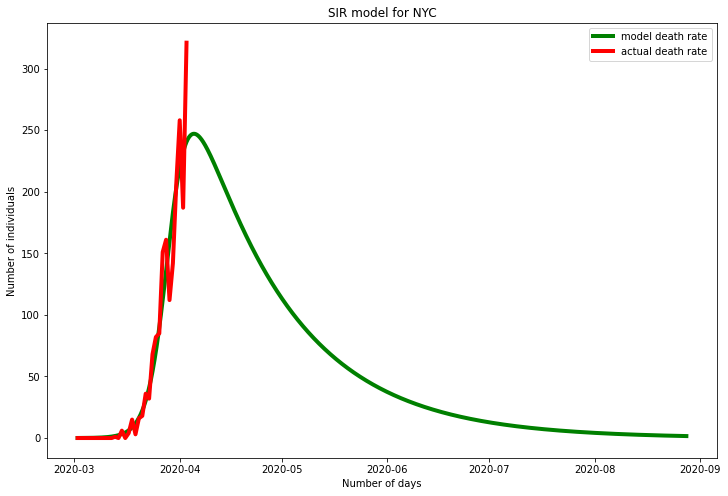

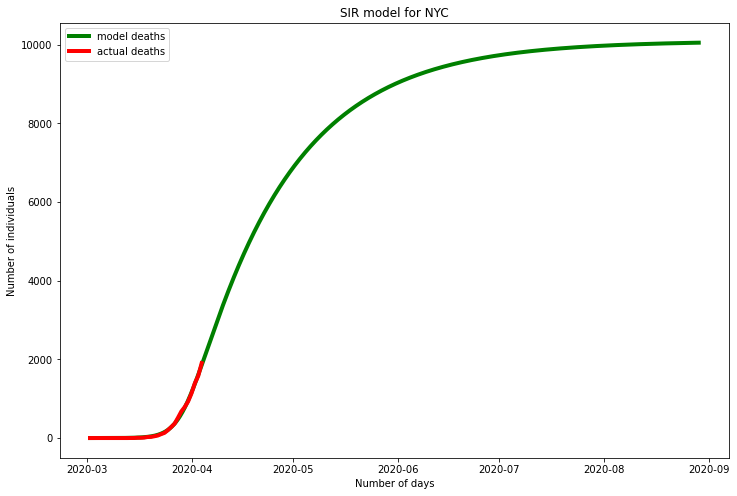

In [145]:
plot_sir_model(r, i, new_york_df, sampling_rate, 'NYC')

## Try model on New Orleans death rates

In [103]:
new_orleans_df = county_df[(county_df.Province_State == 'Louisiana') & (county_df.County == 'Orleans')]

In [114]:
# Normalize death_rate 
# Best for New Orleans: contacts: 0.376 death_rate: 0.0062 days_to_recover: 27.5, mse: 346.53
sampling_rate = 10 # Samples per day
total_days = 150 # Total number of days to simulate
days_to_recover_grid = np.arange(27.5, 28, 1) # Fix this value
contacts_per_day_grid = np.arange(0.3, 0.6, 0.01)
death_rate_grid = np.arange(0.001, 0.003, 0.0002) # Fix this value

nt, ns, ni, nr, nbest_contacts, nbest_death_rate, nbest_days_to_recover, nbest_mse = sir_param_search(
    new_orleans_df, contacts_per_day_grid, death_rate_grid, days_to_recover_grid, sampling_rate, total_days)
print('best_contact:', nbest_contacts)
print('best_death_rate:', nbest_death_rate)
print('best_days_to_recover:', nbest_days_to_recover)
print('best_mse', nbest_mse)

best_contact: 0.5200000000000002
best_death_rate: 0.0012000000000000001
best_days_to_recover: 27.5
best_mse 14.757374742128864


In [113]:
# What is normalized death rate by actual New York population (8.6 mil). Pretty close to New Orleans!
0.0062 / 8600000 * 1628706

0.001174183395348837

peak date 2020-03-29 14:24:00


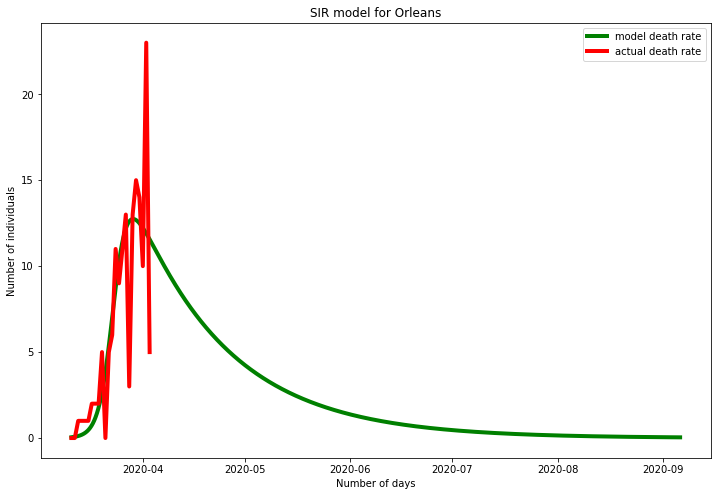

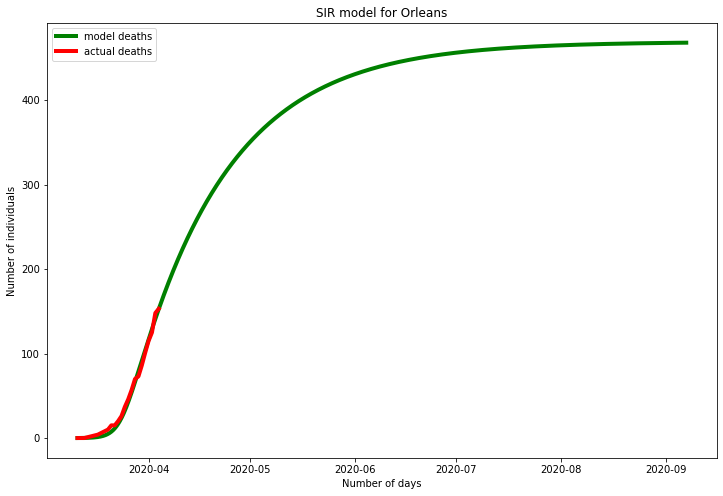

In [146]:
plot_sir_model(nr, ni, new_orleans_df, sampling_rate, 'Orleans')

## Try on Detroit

In [118]:
wayne_county_df = county_df[(county_df.Province_State == 'Michigan') & (county_df.County == 'Wayne')]
wayne_county_df

,FIPS,County,Province_State,Country_Region,Date,Cases,Deaths,Population
14264,26163.0,Wayne,Michigan,US,2020-03-11,1,0,1749343
14265,26163.0,Wayne,Michigan,US,2020-03-12,1,0,1749343
14266,26163.0,Wayne,Michigan,US,2020-03-13,2,0,1749343
14267,26163.0,Wayne,Michigan,US,2020-03-14,6,0,1749343
14268,26163.0,Wayne,Michigan,US,2020-03-15,8,0,1749343
14269,26163.0,Wayne,Michigan,US,2020-03-16,14,0,1749343
14270,26163.0,Wayne,Michigan,US,2020-03-17,14,0,1749343
14271,26163.0,Wayne,Michigan,US,2020-03-18,23,1,1749343
14272,26163.0,Wayne,Michigan,US,2020-03-19,44,1,1749343
14273,26163.0,Wayne,Michigan,US,2020-03-20,67,1,1749343


In [126]:
# Normalize death_rate 
# Best for New Orleans: contacts: 0.376 death_rate: 0.0062 days_to_recover: 27.5, mse: 346.53
sampling_rate = 10 # Samples per day
total_days = 150 # Total number of days to simulate
days_to_recover_grid = np.arange(27, 28, 0.2) # Fix this value
contacts_per_day_grid = np.arange(0.3, 0.6, 0.01)
death_rate_grid = np.arange(0.0005, 0.0015, 0.0001) # Fix this value

wt, ws, wi, wr, wbest_contacts, wbest_death_rate, wbest_days_to_recover, wbest_mse = sir_param_search(
    wayne_county_df, contacts_per_day_grid, death_rate_grid, days_to_recover_grid, sampling_rate, total_days)
print('best_contact:', wbest_contacts)
print('best_death_rate:', wbest_death_rate)
print('best_days_to_recover:', wbest_days_to_recover)
print('best_mse', wbest_mse)

best_contact: 0.4200000000000001
best_death_rate: 0.0010000000000000002
best_days_to_recover: 27.799999999999997
best_mse 17.981736309932216


peak date 2020-04-06 07:12:00


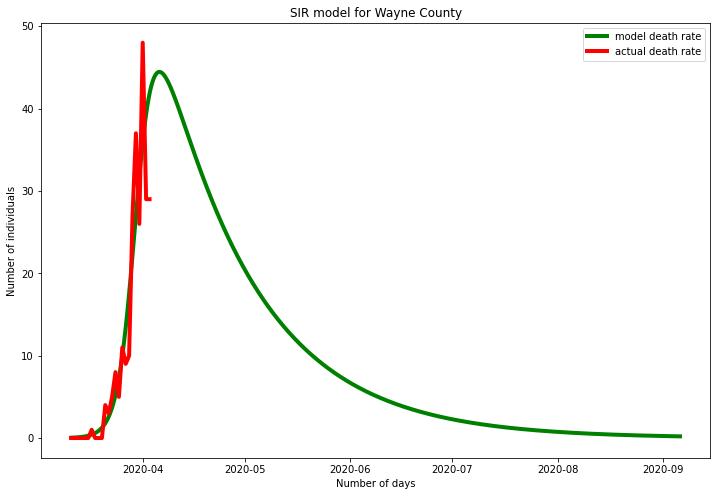

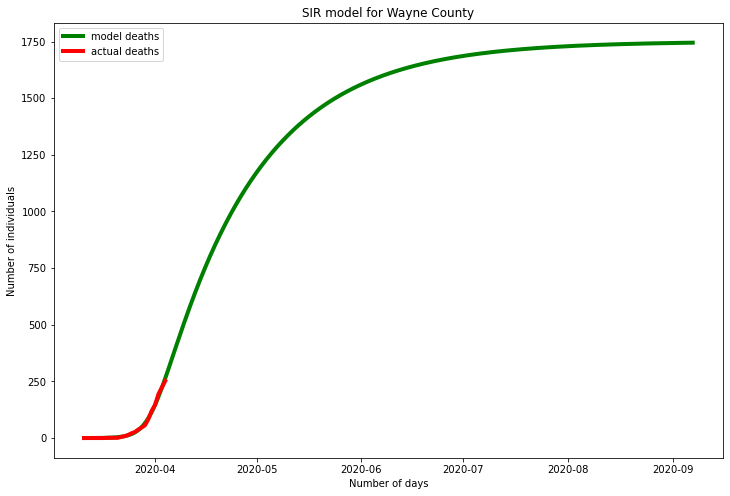

In [147]:
plot_sir_model(wr, wi, wayne_county_df, sampling_rate, 'Wayne County')

## Try on King County

In [131]:
king_county_df = county_df[(county_df.Province_State == 'Washington') & (county_df.County == 'King')]
king_county_df

,FIPS,County,Province_State,Country_Region,Date,Cases,Deaths,Population
30368,53033.0,King,Washington,US,2020-01-22,1,0,2252782
30369,53033.0,King,Washington,US,2020-01-23,1,0,2252782
30370,53033.0,King,Washington,US,2020-01-24,1,0,2252782
30371,53033.0,King,Washington,US,2020-01-25,1,0,2252782
30372,53033.0,King,Washington,US,2020-01-26,1,0,2252782
...,...,...,...,...,...,...,...,...
30437,53033.0,King,Washington,US,2020-03-31,2330,150,2252782
30438,53033.0,King,Washington,US,2020-04-01,2330,150,2252782
30439,53033.0,King,Washington,US,2020-04-02,2656,175,2252782
30440,53033.0,King,Washington,US,2020-04-03,2787,186,2252782


In [138]:
# Normalize death_rate 
sampling_rate = 10 # Samples per day
total_days = 150 # Total number of days to simulate
days_to_recover_grid = np.arange(27, 28, 0.2) # Fix this value
contacts_per_day_grid = np.arange(0.1, 0.2, 0.002)
death_rate_grid = np.arange(0.001, 0.0015, 0.0001) # Fix this value

kt, ks, ki, kr, kbest_contacts, kbest_death_rate, kbest_days_to_recover, kbest_mse = sir_param_search(
    king_county_df, contacts_per_day_grid, death_rate_grid, days_to_recover_grid, sampling_rate, total_days)
print('best_contact:', kbest_contacts)
print('best_death_rate:', kbest_death_rate)
print('best_days_to_recover:', kbest_days_to_recover)
print('best_mse', kbest_mse)

best_contact: 0.12400000000000003
best_death_rate: 0.0012000000000000001
best_days_to_recover: 27.799999999999997
best_mse 29.89750299564192


peak date 2020-05-02 12:00:00


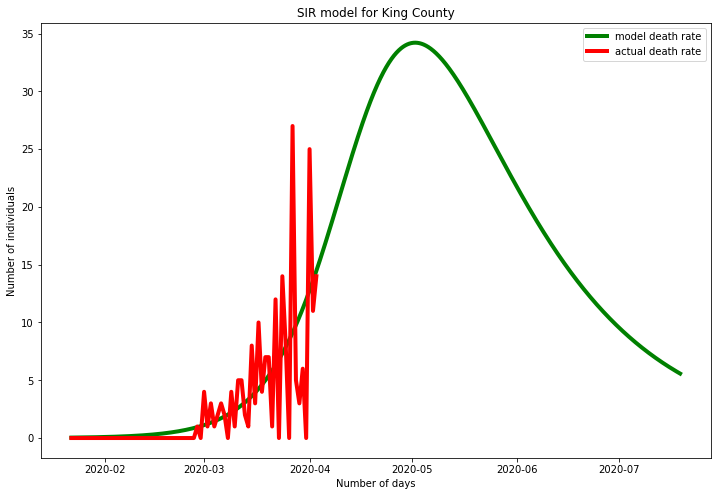

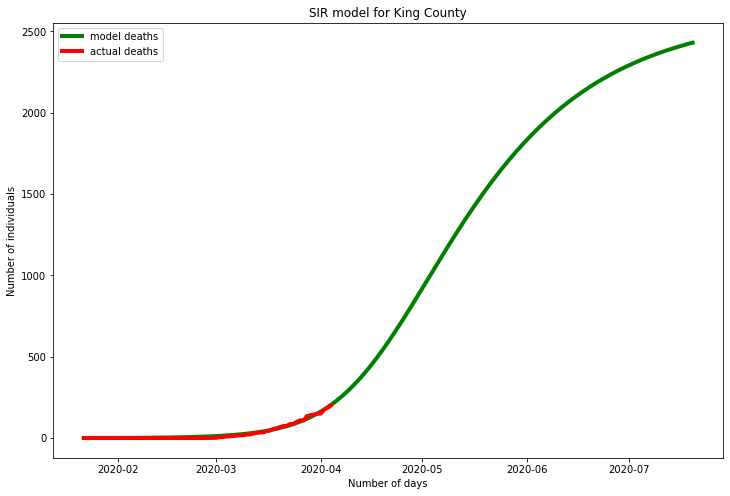

In [148]:
plot_sir_model(kr, ki, king_county_df, sampling_rate, 'King County')